1/1 [==============================] - 0s 448ms/step
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 13.2430 - accuracy: 0.8549
Epoch 1: val_loss improved from inf to 1.61540, saving model to E:/my_model\test.h5
27/27 [==============================] - 18s 628ms/step - loss: 13.2430 - accuracy: 0.8549 - val_loss: 1.6154 - val_accuracy: 0.9892
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.5891 - accuracy: 0.9820
Epoch 2: val_loss improved from 1.61540 to 1.23751, saving model to E:/my_model\test.h5
27/27 [==============================] - 16s 594ms/step - loss: 1.5891 - accuracy: 0.9820 - val_loss: 1.2375 - val_accuracy: 0.9820
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.9856
Epoch 3: val_loss improved from 1.23751 to 0.62862, saving model to E:/my_model\test.h5
27/27 [==============================] - 16s 596ms/step - loss: 0.4340 - accuracy: 0.9856 - val_loss: 0.6286 - val_accuracy: 0.9892
Epoch 4

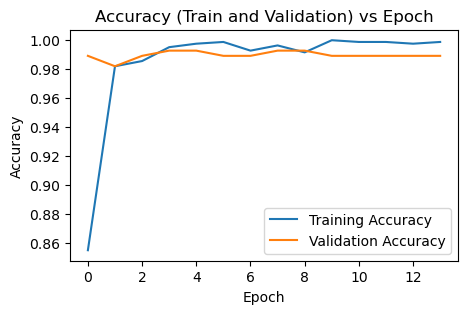

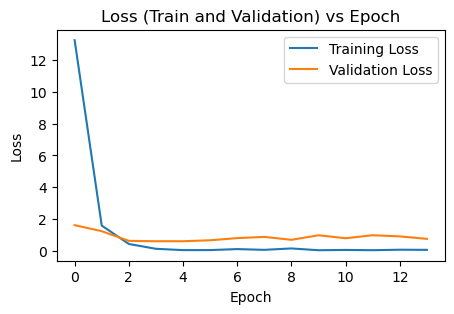

9/9 [==============================] - 1s 81ms/step - loss: 0.3876 - accuracy: 0.9856
Test loss: 0.3875598907470703
Test accuracy: 0.9856114983558655
9/9 [==============================] - 1s 91ms/step - loss: 0.6051 - accuracy: 0.9928
Validation loss: 0.6050694584846497
Validation accuracy: 0.9928057789802551
9/9 [==============================] - 1s 73ms/step

 Note Path | Predicted Label | Original Label 
---------------------------------------------
 E:/modified_dataset\fake_notes\note_135 | fake | fake
 E:/modified_dataset\fake_notes\note_029 | fake | fake
 E:/modified_dataset\fake_notes\note_317 | fake | fake
 E:/modified_dataset\real_notes\note_289 | real | real
 E:/modified_dataset\fake_notes\note_099 | fake | fake
 E:/modified_dataset\real_notes\note_559 | real | real
 E:/modified_dataset\fake_notes\note_463 | fake | fake
 E:/modified_dataset\fake_notes\note_569 | fake | fake
 E:/modified_dataset\fake_notes\note_454 | fake | fake
 E:/modified_dataset\real_notes\note_376 | real

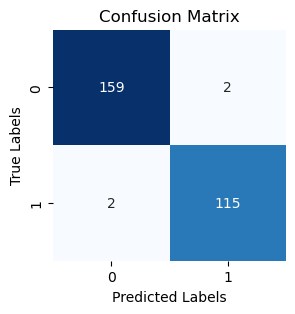

Precision: 0.98
Recall: 0.98
F1 score: 0.98
9/9 [==============================] - 1s 75ms/step


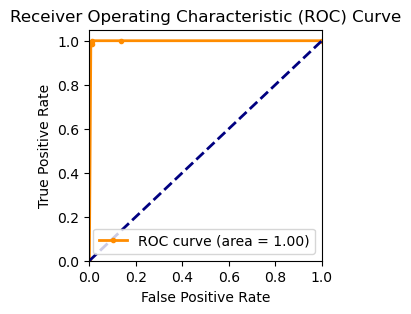

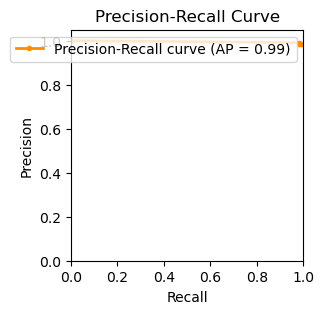

In [1]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Set the seed for reproducibility
#seed = 42
seed = 123

np.random.seed(seed)
tf.random.set_seed(seed)

# Define the directory where the dataset is stored
dataset_dir = 'E:/modified_dataset'

# Define the image size and channels
img_size = (224, 224)
img_channels = 3

# Define the number of notes in the dataset
num_notes = len(os.listdir(os.path.join(dataset_dir, 'real_notes'))) + len(os.listdir(os.path.join(dataset_dir, 'fake_notes'))) 

# Define the ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))

def extract_features(dataset_dir, resnet_model):
    features_list = []
    labels_list = []
    note_paths_list = []

    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)

        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)

            
            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])
            images = []

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')

                image = cv2.imread(image_path)
                image = cv2.resize(image, img_size)
                image = preprocess_input(image)
                images.append(image)

            features = resnet_model.predict(np.array(images))
            features = features.reshape((1, num_images_per_note, 7, 7, 2048))

            features_list.append(features)
            if class_dir == 'real_notes':
                labels_list.append(0)
            else:
                labels_list.append(1)

            note_paths_list.append(note_path)

    X = np.vstack(features_list)
    y = np.array(labels_list)

    return X, y, note_paths_list

X, y, note_paths = extract_features(dataset_dir, resnet_model)

X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(X, y, note_paths, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=seed)


input_tensor = Input(shape=(X.shape[1], 7, 7, 2048))

split_tensors = Lambda(lambda x: tf.unstack(x, axis=1))(input_tensor)
branches = [Flatten()(split_tensors[i]) for i in range(X.shape[1])]
concat = Concatenate()(branches)
dropout = Dropout(0.6)(concat)
fcnn = Dense(64, activation='relu', kernel_regularizer=l2(0.00005))(dropout)  # Added L2 regularization
fcnn = Dense(1, activation='sigmoid')(fcnn)
model = Model(inputs=input_tensor, outputs=fcnn)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#Saving the best Model
# Define the directory where you want to save the best model
best_model_dir = 'E:/my_model'

# Create the directory if it does not exist
os.makedirs(best_model_dir, exist_ok=True)

# Define the ModelCheckpoint callback with the updated file path
best_model_file_path = os.path.join(best_model_dir, 'test.h5')
checkpoint = ModelCheckpoint(best_model_file_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
# Import the necessary libraries
import matplotlib.pyplot as plt

# Plot the training and validation accuracy vs epoch
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Train and Validation) vs Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss vs epoch
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Train and Validation) vs Epoch')
plt.legend(loc='upper right')
plt.show()

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model(best_model_file_path)

test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")



# Evaluate the best model on the validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")




# Get the predicted labels
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)


# Function to convert numerical labels to string labels
def label_to_string(label):
    return "real" if label == 0 else "fake"

# Print the original labels, predicted labels, and note_paths for the test set
print("\n Note Path | Predicted Label | Original Label ")
print("-" * 45)
for original_label, predicted_label, note_path in zip(y_test, predicted_labels.flatten(), note_paths_test):
    print(f" {note_path} | {label_to_string(predicted_label)} | {label_to_string(original_label)}")

# Import the necessary libraries
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax , fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()



# Calculate and print precision, recall, and F1 score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

from sklearn.metrics import roc_curve, auc

# Make predictions using the best model and get probabilities
y_pred_probs = best_model.predict(X_test)

# Calculate the FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, marker='o', markersize=3 , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate the average precision
average_precision = average_precision_score(y_test, y_pred_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(3, 3))
plt.plot(recall, precision, color='darkorange', lw=2,marker='o', markersize=3, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()







In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

def predict_note_type(model, note_path):
    img_size = (224, 224)
    img_channels = 3
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))
    note_images = []
    for i in range(1, 7):
        image_path = os.path.join(note_path, f'{note_path.split("/")[-1]}_{i}.jpg')
        print(f"Loading image: {image_path}")
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
        note_images.append(image)
    
    preprocessed_images = []
    for image in note_images:
        image = cv2.resize(image, img_size)
        image = preprocess_input(image)
        image_features = resnet_model.predict(np.expand_dims(image, axis=0))
        preprocessed_images.append(image_features.reshape((1, 7, 7, 2048)))
    
    X_features = np.concatenate(preprocessed_images, axis=0)
    X_features = X_features.reshape((1, 6, 7, 7, 2048))

    
    

    # Make predictions on the input images
    y_pred = model.predict(X_features)
    y_pred_binary = (y_pred > 0.5).astype(int)
    return y_pred_binary[0][0]

note_path = 'E:/modified_dataset/fake_notes/note_503'
model = load_model('E:/my_model/test.h5')
model.summary()
result = predict_note_type(model, note_path)
if result == 0:
    print("Your note is real")
else:
    print("Your note is fake")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 7, 7, 20  0           []                               
                                48)]                                                              
                                                                                                  
 lambda (Lambda)                [(None, 7, 7, 2048)  0           ['input_2[0][0]']                
                                , (None, 7, 7, 2048                                               
                                ),                                                                
                                 (None, 7, 7, 2048)                                               
                                , (None, 7, 7, 2048                                           